In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [30]:
data=pd.read_csv('C:/Users/yashg/Documents/Cloud_Data_Files/varying_extinction/alldates/data_21082020.csv')
data_cut=(data[data['LWC']>0])
data_cut.columns

Index(['Unnamed: 0', 'Date', 'Time', 'Height', 'LWC', 'LWC_SD', 'Velocity',
       'Velocity_SD', 'Spectral_Width', 'Spectral_Width_SD', 'Reflectivity',
       'Reflectivity_SD', 'Temperature', 'Extinction_low', 'Extinction',
       'Extinction_high', 'CCN'],
      dtype='object')

# Calculating Cloud Droplet Concentration using Pinsky correlation

In [31]:
#Parameters
A=8.07131
B=1730.63
C=233.426
l=2260000 #J/kg
a_cond=0.022 #W/m/K
a_water=5.5575 #W/m/K
D=0.399*10**-4 #m^2/s
Ra=287 #J/deg/kg
Rv=461 #J/deg/kg
qv=0.04 #kg/kg
rhow=1000 #kg/m3
rhoa=1.225 #kg/m3
g=9.8 #m2/s
cp=1000 #J/kg
C1=1.058 

In [32]:
def vaporpressure(temp):
    p=10**(A-(B)/(C+temp))
    p=p*133.322
    return p #in pascals

def constants(temp):
    vp=vaporpressure(temp-273.15)
    k=(1.52E-11)*(temp)**3-(4.8574E-8)*(temp)**2+1.0184E-04*(temp)-3.9333E-04
    F=(rhow*(l)**2/k/Rv/(temp)**2)+(rhow*Rv*(temp)/vp/D)
    A1=(g/Ra/temp*((l*Ra/(cp*Rv*temp))-1))
    A2=1/qv+((l)**2/cp/Rv/(temp)**2)
    return k,F,A1,A2

def C3(temp):
    k,F,A1,A2=constants(temp)
    a=C1*(F*A1/3)**0.75
    b=(3*rhoa/4/np.pi/rhow/A2)**0.5
    return a*b

def CDC_pinsky(temp,No,v,k):
    C=C3(temp)/10
    a=C**(2*k/(2+k))
    b=(No)**(2/(2+k))
    c=np.abs(v)**(3*k/(4+2*k))
    return a*b*c

def Smax(temp,No,v,k):
    C=C3(temp)/10
    a=C**(2/(2+k))
    b=(No)**(-1/(2+k))
    c=np.abs(v)**(3/(4+2*k))
    return a*b*c

In [39]:
temp=data_cut['Temperature']
No=data_cut['CCN']
v=data_cut['Velocity_SD']*0.6
k=0.3
cdc_p=CDC_pinsky(temp,No,v,k)

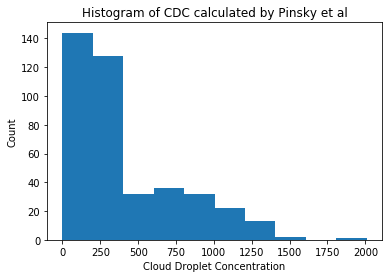

In [40]:
plt.hist(cdc_p)
plt.xlabel('Cloud Droplet Concentration')
plt.ylabel('Count')
plt.title('Histogram of CDC calculated by Pinsky et al')
plt.show()

# Estimating LWC using Pinsky

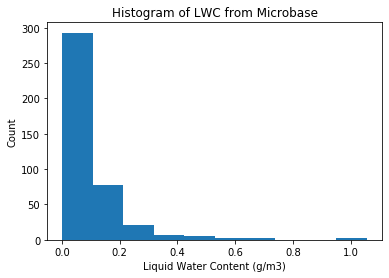

In [72]:
plt.hist(data_cut['LWC'])
plt.xlabel('Liquid Water Content (g/m3)')
plt.ylabel('Count')
plt.title('Histogram of LWC from Microbase')
plt.show()

In [79]:
def lwc(cdc,rhow=1e-3,Dm=0.1,alpha=5):
    p1=np.pi/6*rhow*1/(6+alpha)**3*(Dm**3)
    fac=math.factorial(3+alpha)/math.factorial(alpha)
    n=cdc/1e-6
    l=p1*fac*n
    return l

In [80]:
def prefactor(Dm,alpha,rhow=1e-3):
    x=np.pi/6*rhow*1/(6+alpha)**3*(Dm**3)*math.factorial(3+alpha)/math.factorial(alpha)
    return x

In [81]:
lc=lwc(cdc_p)

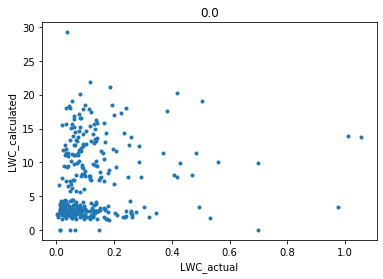

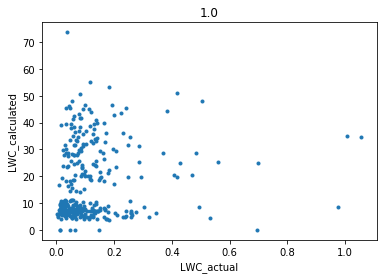

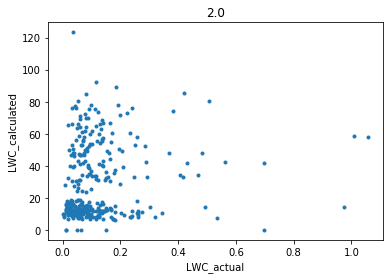

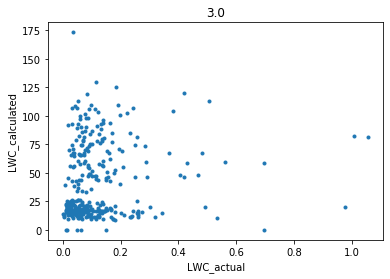

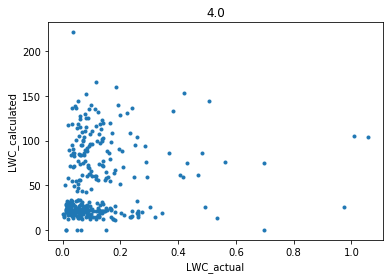

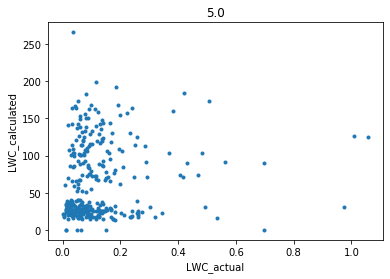

In [83]:
alpha=np.linspace(0,5,6)
for a in alpha:
    lc=lwc(cdc_p,alpha=a)    
    plt.plot(data_cut['LWC'],lc,'.')
    plt.title(a)
    plt.xlabel('LWC_actual')
    plt.ylabel('LWC_calculated')
    plt.show()

In [77]:
a1=[]
d1=[]
l1=[]
alpha=np.linspace(0,5,6)
dm=np.linspace(0,0.25,10)
for a in alpha:
    for d in dm:
        a1.append(a)
        d1.append(d)
        l1.append(prefactor(d,a))
df={'Alpha':a1,'Dm':d1,'Prefactor':l1}
dat=pd.DataFrame(df)
larr=np.array(l1)
larr=np.reshape(larr,(len(alpha),len(dm)))

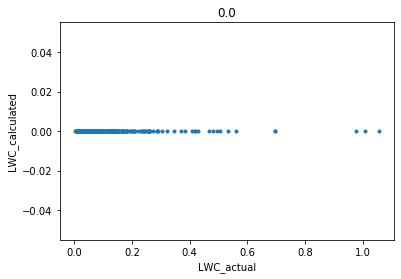

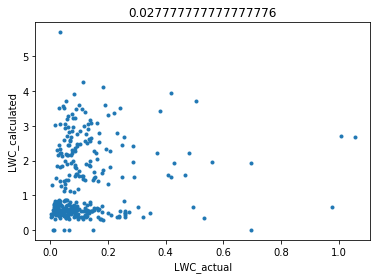

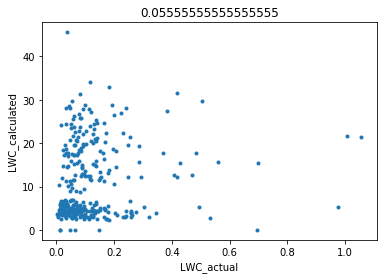

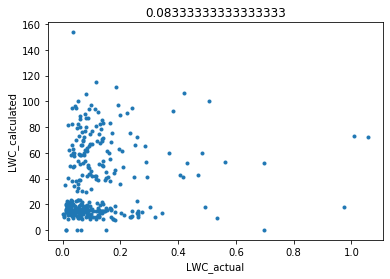

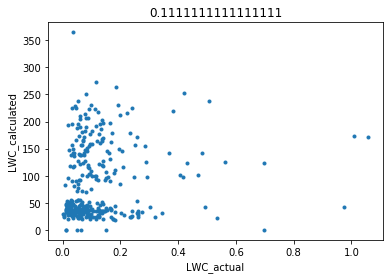

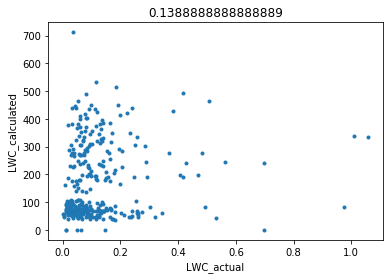

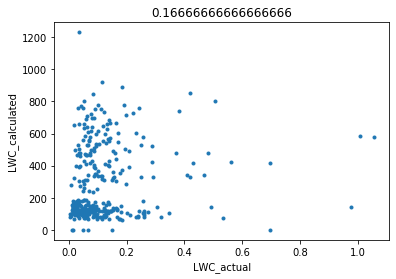

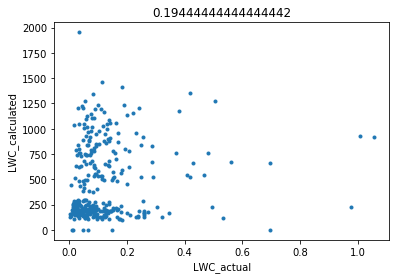

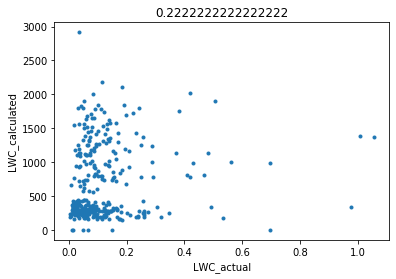

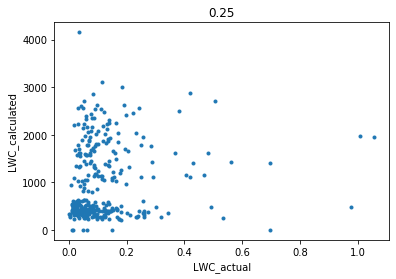

In [84]:
for d in dm:
    lc=lwc(cdc_p,Dm=d)    
    plt.plot(data_cut['LWC'],lc,'.')
    plt.title(d)
    plt.xlabel('LWC_actual')
    plt.ylabel('LWC_calculated')
    plt.show()    

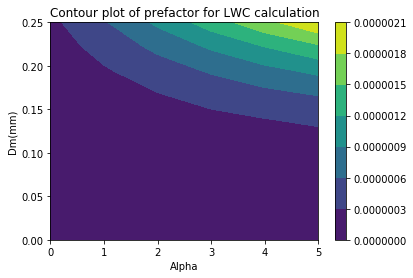

In [78]:
plt.contourf(alpha,dm,larr.T)
plt.xlabel('Alpha')
plt.ylabel('Dm(mm)')
plt.title('Contour plot of prefactor for LWC calculation')
plt.colorbar()
plt.show()

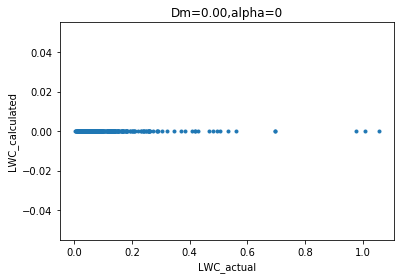

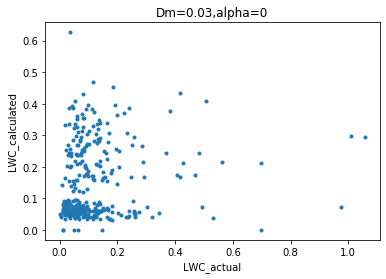

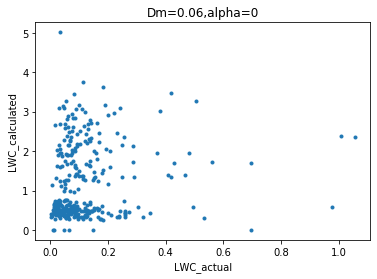

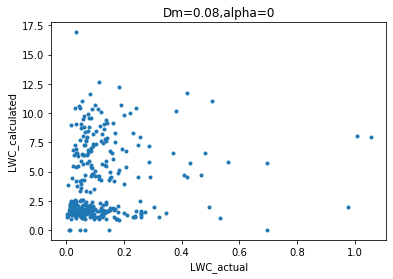

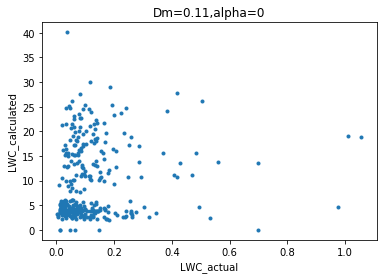

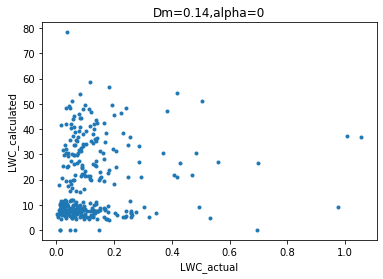

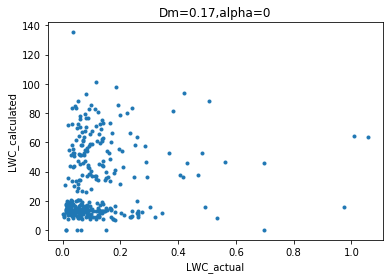

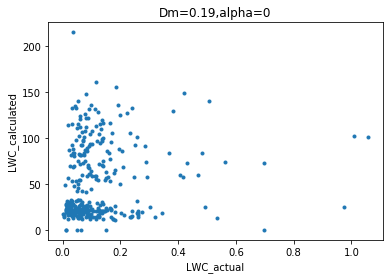

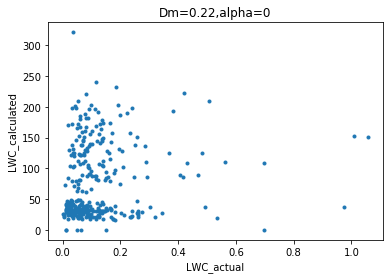

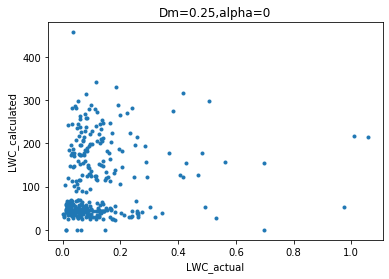

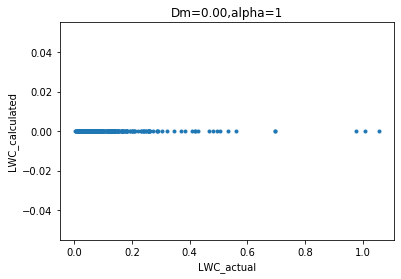

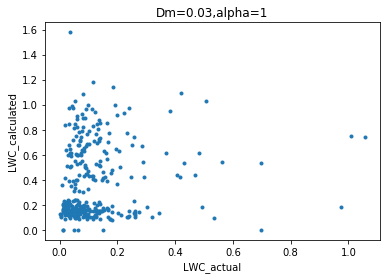

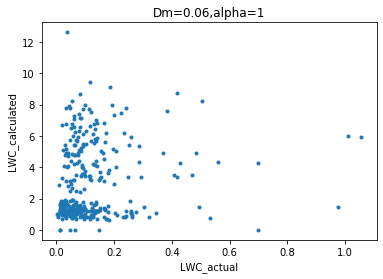

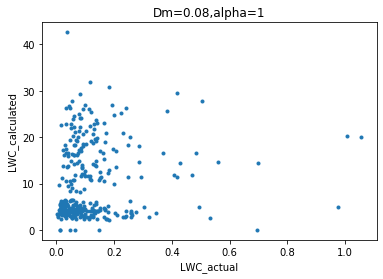

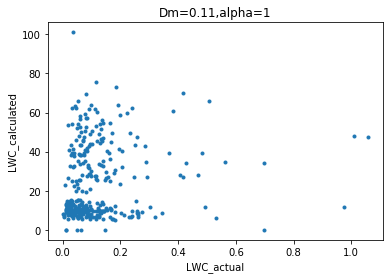

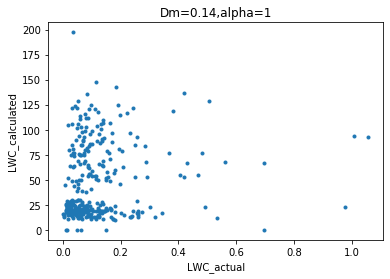

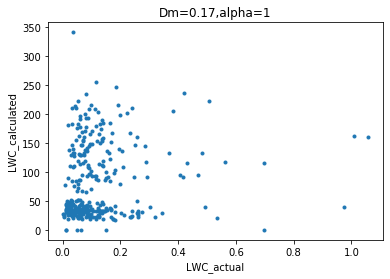

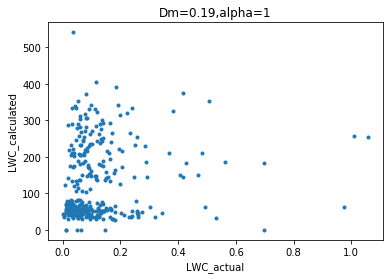

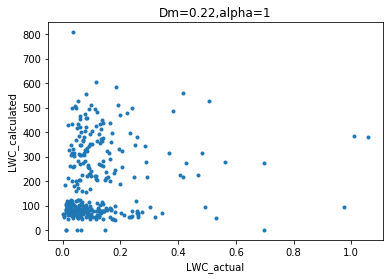

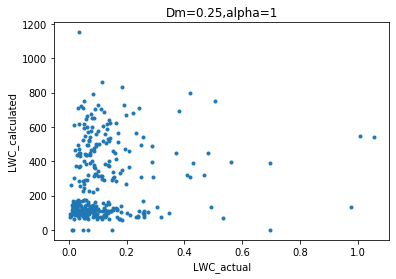

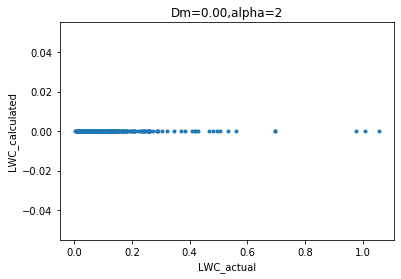

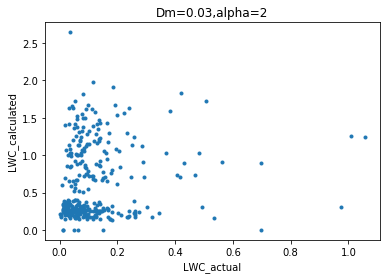

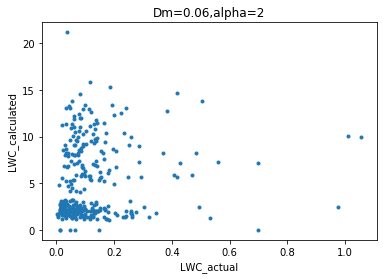

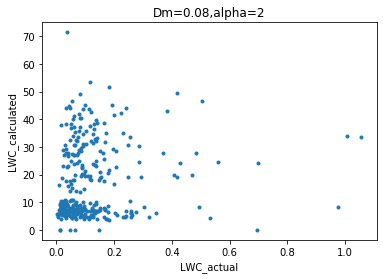

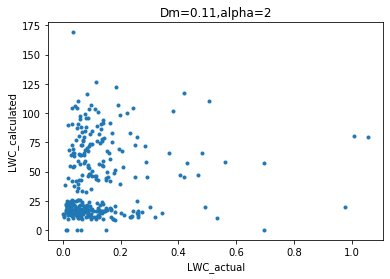

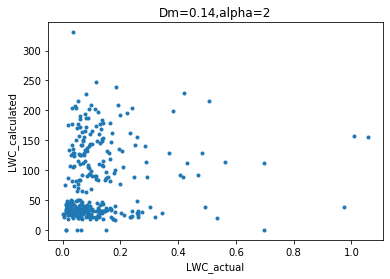

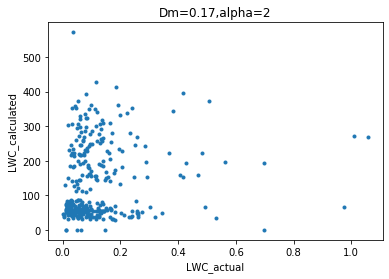

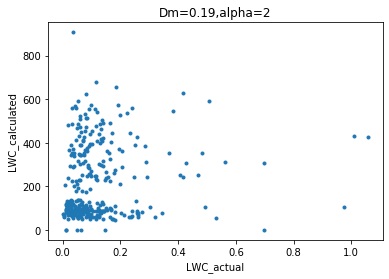

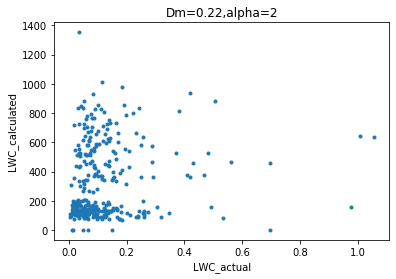

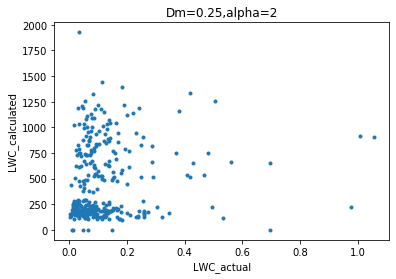

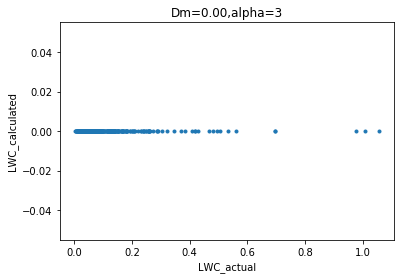

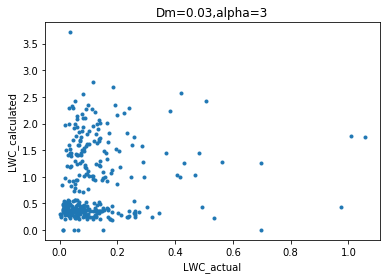

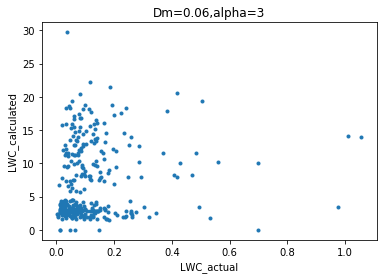

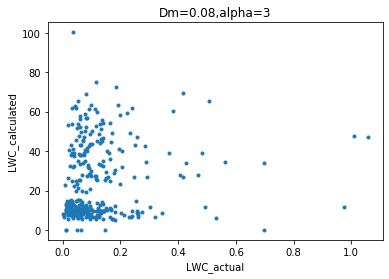

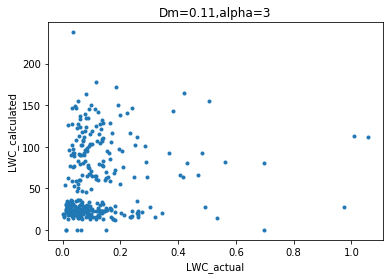

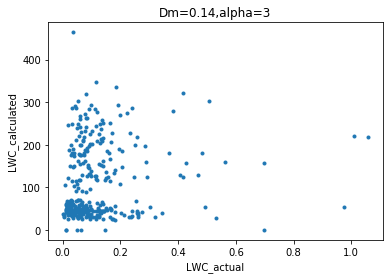

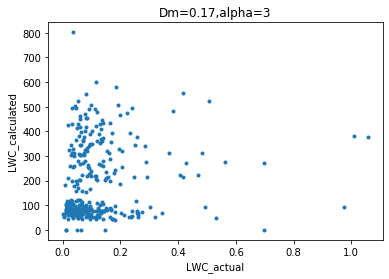

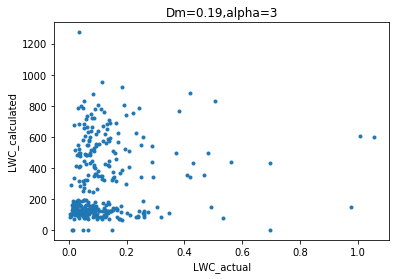

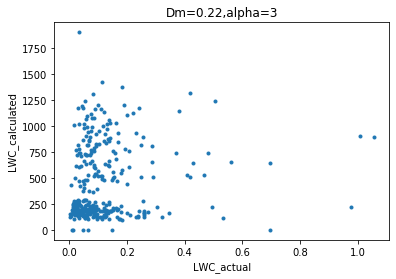

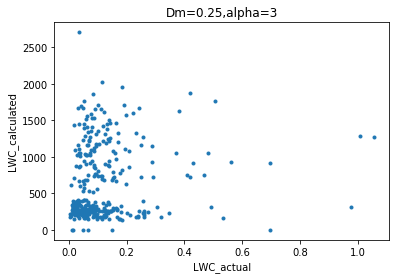

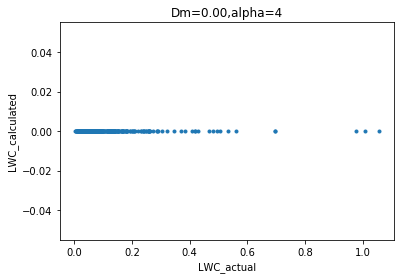

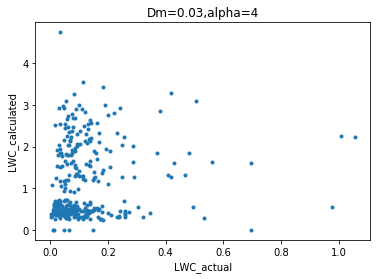

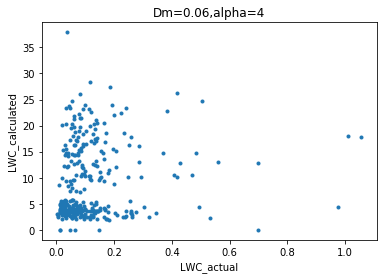

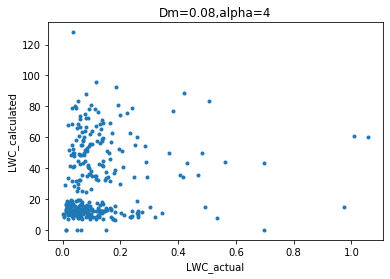

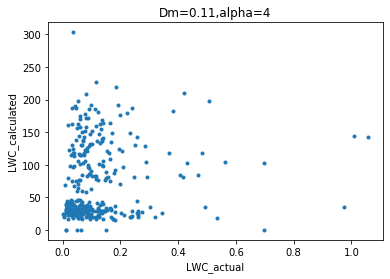

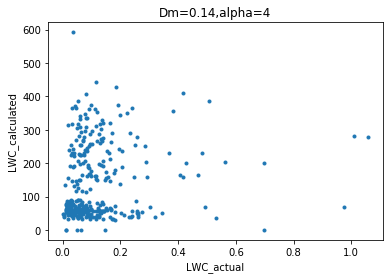

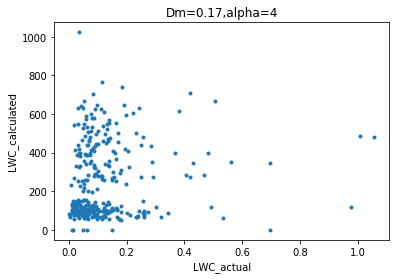

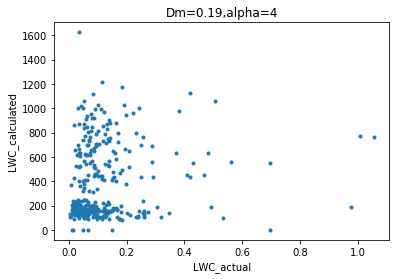

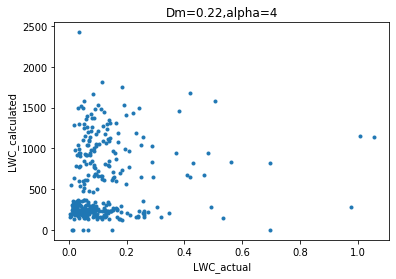

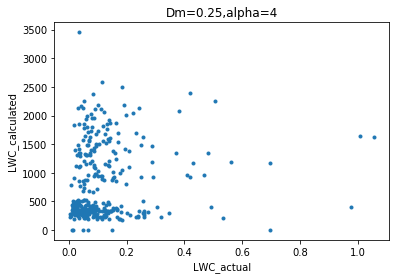

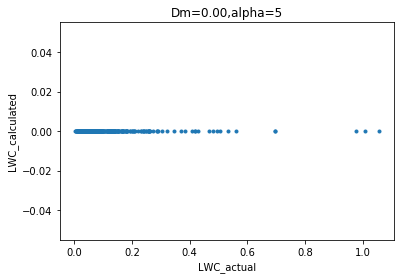

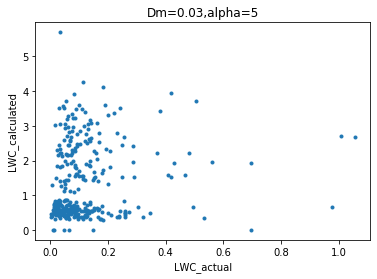

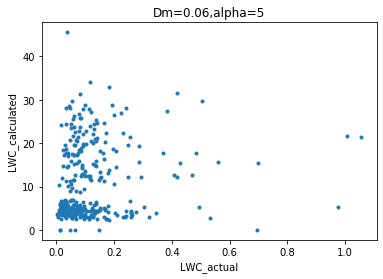

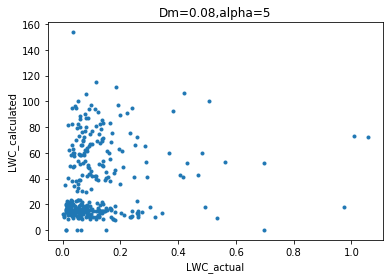

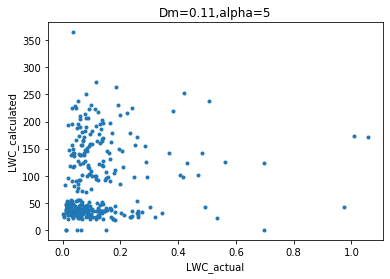

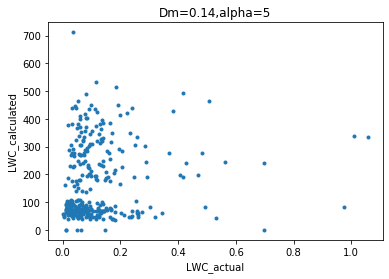

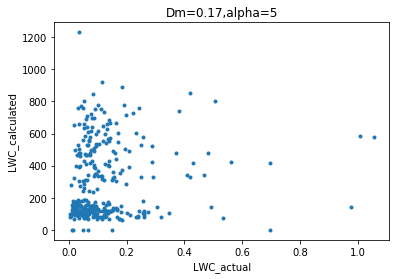

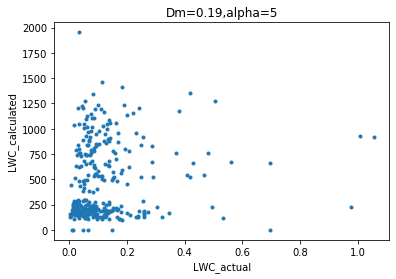

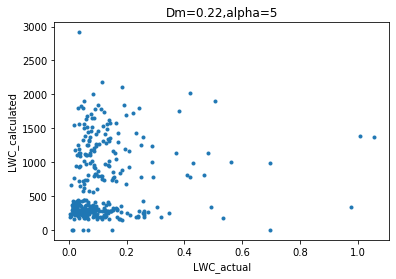

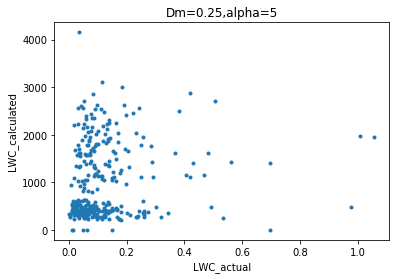

In [89]:
for a in alpha:
    for d in dm:
        lc=lwc(cdc_p,Dm=d,alpha=a)    
        m=np.max(lc)
        plt.plot(data_cut['LWC'],lc,'.')
        plt.title(f'Dm={d:1.2f},alpha={int(a)}')
        plt.xlabel('LWC_actual')
        plt.ylabel('LWC_calculated')
        plt.savefig(f'C:/Users/yashg/Documents/Cloud_Data_Files/lwc_plots/alpha_{a}_Dm_{d:1.2f}.jpg')
        plt.show()